**GOALS**:
- Explore data
- Extract features to build classification models

***

 To do so, I've read this [awesome kernel](https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction) which gives many simple insights on the data content and [this one](https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script) which led to this [github code](https://github.com/js-aguiar/home-credit-default-competition/blob/master/README.md).

 The goal of this project is not to focus on the refinement of the cleansing nor the feature engineering but rather to focus on the MLOps part (models tracking and deployment, API for inference, and dashboard).
 
 Thus, I extracted features into pickle files thanks to Aguiar's github script that I've slightly adapted to my pandas version.

 This notebook helps to discover briefly these features and get a sense of what Aguiar did observing results while reading through corresponding functions.

 Finally, it merges everything into one usable compressed csv.gz file.
 
  

**Table of contents**<a id='toc0_'></a>    
- 1. [Paths](#toc1_)    
- 2. [Original Features descriptions in the tables](#toc2_)    
- 3. [Distribution of the target](#toc3_)    
- 4. [Read feature dataframes](#toc4_)    
- 5. [Explore engineered features](#toc5_)    
  - 5.1. [Bureau and balance](#toc5_1_)    
  - 5.2. [Application](#toc5_2_)    
  - 5.3. [Previous](#toc5_3_)    
  - 5.4. [Pos_cash](#toc5_4_)    
  - 5.5. [Payments](#toc5_5_)    
  - 5.6. [Credit_card](#toc5_6_)    
- 6. [Merge features](#toc6_)    
- 7. [Nulls quick exploration](#toc7_)    
- 8. [Add extra ratio features](#toc8_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import missingno as msno
import gc

# 1.  [&#9650;](#toc0_) <a id='toc1_'></a>Paths

In [2]:
APPLICATION_TRAIN_PATH = './data/application_train.csv'
APPLICATION_TEST_PATH = './data/application_test.csv'
BUREAU_PATH = './data/bureau.csv'
BUREAU_BALANCE_PATH = './data/bureau_balance.csv'
CREDIT_CARD_BALANCE_PATH = './data/credit_card_balance.csv'
INSTALLMENTS_PAYMENTS_PATH = './data/installments_payments.csv'
PREVIOUS_APPLICATION_PATH = './data/previous_application.csv'
SAMPLE_SUBMISSION_PATH = './data/sample_submission.csv'
POS_CASH_BALANCE_PATH = './data/POS_CASH_balance.csv'
COLUMNS_DESCRIPTION_PATH = './data/HomeCredit_columns_description.csv'

# 2.  [&#9650;](#toc0_) <a id='toc2_'></a>Original Features descriptions in the tables

In [3]:
desc_df = pd.read_csv(
    COLUMNS_DESCRIPTION_PATH,
    index_col=0,
    encoding_errors='ignore',
)

desc_df.head()

,Table,Row,Description,Special
1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


In [22]:
for table_name in desc_df.Table.unique():
    print(f"\n### TABLE NAME : {table_name} ###\n")
    df = desc_df.query('Table == @table_name')
    for index, row in df.drop(['Table', 'Special'], axis=1).iterrows():
        print('{:>30} : {} '.format(row.Row, row.Description))
    


### TABLE NAME : application_{train|test}.csv ###

                    SK_ID_CURR : ID of loan in our sample 
                        TARGET : Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases) 
            NAME_CONTRACT_TYPE : Identification if loan is cash or revolving 
                   CODE_GENDER : Gender of the client 
                  FLAG_OWN_CAR : Flag if the client owns a car 
               FLAG_OWN_REALTY : Flag if client owns a house or flat 
                  CNT_CHILDREN : Number of children the client has 
              AMT_INCOME_TOTAL : Income of the client 
                    AMT_CREDIT : Credit amount of the loan 
                   AMT_ANNUITY : Loan annuity 
               AMT_GOODS_PRICE : For consumer loans it is the price of the goods for which the loan is given 
               NAME_TYPE_SUITE : Who was accompanying client

# 3.  [&#9650;](#toc0_) <a id='toc3_'></a>Distribution of the target

In [32]:
df = pd.read_csv(APPLICATION_TRAIN_PATH)
df.shape

(307511, 122)

In [38]:
df.TARGET.value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

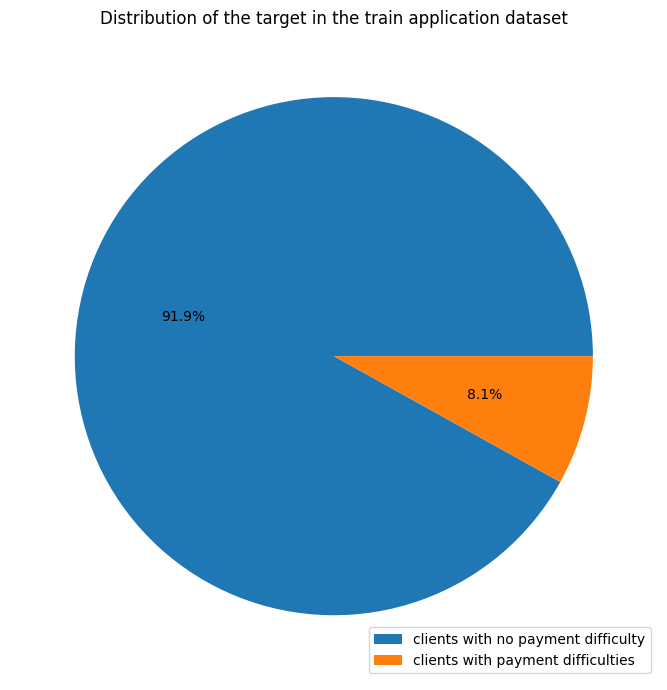

In [66]:
labels = ['clients with no payment difficulty', 'clients with payment difficulties']

fig = plt.figure(figsize=(7,7))
plt.pie(df.TARGET.value_counts().values, labels=None, autopct='%1.1f%%')
plt.legend(labels, loc="lower right")
plt.title("Distribution of the target in the train application dataset")
plt.tight_layout()
plt.show()

This is an unbalanced classification problem

# 4.  [&#9650;](#toc0_) <a id='toc4_'></a>Read feature dataframes

In [3]:
PICKLE_FILES_PATHS = glob.glob('./pickle_files/*')
PICKLE_FILES_PATHS

['./pickle_files/bureau_and_balance.pkl',
 './pickle_files/payments.pkl',
 './pickle_files/credit_card.pkl',
 './pickle_files/previous.pkl',
 './pickle_files/pos_cash.pkl',
 './pickle_files/application.pkl']

In [4]:
df_names = [path.split('/')[-1].removesuffix('.pkl') 
            for path in PICKLE_FILES_PATHS]
df_names

['bureau_and_balance',
 'payments',
 'credit_card',
 'previous',
 'pos_cash',
 'application']

In [5]:
for path, df_name in zip(PICKLE_FILES_PATHS, df_names):
    print(df_name)
    exec(f"{df_name} = pd.read_pickle('{path}')")
    print(eval(df_name).shape)

bureau_and_balance
(305811, 173)
payments
(339587, 101)
credit_card
(103558, 59)
previous
(338857, 242)
pos_cash
(337252, 24)
application
(356250, 124)


# 5.  [&#9650;](#toc0_) <a id='toc5_'></a>Explore engineered features

## 5.1.  [&#9650;](#toc0_) <a id='toc5_1_'></a>Bureau and balance

In [21]:
bureau_and_balance.head()

,SK_ID_CURR,BUREAU_SK_ID_BUREAU_NUNIQUE,BUREAU_DAYS_CREDIT_MIN,BUREAU_DAYS_CREDIT_MAX,BUREAU_DAYS_CREDIT_MEAN,BUREAU_DAYS_CREDIT_ENDDATE_MIN,BUREAU_DAYS_CREDIT_ENDDATE_MAX,BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_AMT_CREDIT_SUM_MAX,...,BUREAU_LAST36M_AMT_CREDIT_SUM_SUM,BUREAU_LAST36M_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_LAST36M_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_LAST36M_DEBT_PERCENTAGE_MEAN,BUREAU_LAST36M_DEBT_CREDIT_DIFF_MEAN,BUREAU_LAST36M_STATUS_0_MEAN,BUREAU_LAST36M_STATUS_12345_MEAN,AMT_CREDIT_MAX_OVERDUE,BUREAU_DEBT_OVER_CREDIT,BUREAU_ACTIVE_DEBT_OVER_CREDIT
0,100001,7,-1572,-49,-735.000,-1329.0,1778.0,NaN,NaN,378000.000000,...,1.367865e+06,99447.75,596686.5,NaN,128529.750000,0.389648,0.008774,NaN,0.410555,0.674966
1,100002,8,-1437,-103,-874.000,-1072.0,780.0,5043.64502,1681.029053,450000.000000,...,6.702236e+05,61445.25,245781.0,NaN,89235.640625,0.362549,0.250000,40.5,0.284122,0.509931
2,100003,4,-2586,-606,-1401.000,-2434.0,1216.0,0.00000,0.000000,810000.000000,...,8.826525e+05,0.00,0.0,NaN,441326.250000,NaN,NaN,0.0,0.000000,0.000000
3,100004,2,-1326,-408,-867.000,-595.0,-382.0,0.00000,0.000000,94537.796875,...,9.453780e+04,0.00,0.0,inf,94537.796875,NaN,NaN,0.0,0.000000,NaN
4,100005,3,-373,-62,-190.625,-128.0,1324.0,0.00000,0.000000,568800.000000,...,6.571260e+05,189469.50,568408.5,NaN,29572.500000,0.734863,0.000000,0.0,0.864992,0.949522


In [23]:
list(bureau_and_balance.columns)

['SK_ID_CURR',
 'BUREAU_SK_ID_BUREAU_NUNIQUE',
 'BUREAU_DAYS_CREDIT_MIN',
 'BUREAU_DAYS_CREDIT_MAX',
 'BUREAU_DAYS_CREDIT_MEAN',
 'BUREAU_DAYS_CREDIT_ENDDATE_MIN',
 'BUREAU_DAYS_CREDIT_ENDDATE_MAX',
 'BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX',
 'BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'BUREAU_AMT_CREDIT_SUM_MAX',
 'BUREAU_AMT_CREDIT_SUM_MEAN',
 'BUREAU_AMT_CREDIT_SUM_SUM',
 'BUREAU_AMT_CREDIT_SUM_DEBT_MAX',
 'BUREAU_AMT_CREDIT_SUM_DEBT_MEAN',
 'BUREAU_AMT_CREDIT_SUM_DEBT_SUM',
 'BUREAU_AMT_CREDIT_SUM_OVERDUE_MAX',
 'BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN',
 'BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM',
 'BUREAU_AMT_ANNUITY_MEAN',
 'BUREAU_DEBT_CREDIT_DIFF_MEAN',
 'BUREAU_DEBT_CREDIT_DIFF_SUM',
 'BUREAU_MONTHS_BALANCE_MEAN_MEAN',
 'BUREAU_MONTHS_BALANCE_MEAN_VAR',
 'BUREAU_MONTHS_BALANCE_SIZE_MEAN',
 'BUREAU_MONTHS_BALANCE_SIZE_SUM',
 'BUREAU_STATUS_0_MEAN',
 'BUREAU_STATUS_1_MEAN',
 'BUREAU_STATUS_12345_MEAN',
 'BUREAU_STATUS_C_MEAN',
 'BUREAU_STATUS_X_MEAN',
 'BUREAU_CREDIT_ACTIVE_Active_MEAN',
 'BUREAU_CR

In this features, per SK_ID_CURR, the number of known loans in another credit company are summarized and grouped, and statistics are made on those groups (sometimes over a time-window).

## 5.2.  [&#9650;](#toc0_) <a id='toc5_2_'></a>Application

In [24]:
application.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,GROUP2_EXT_SOURCES_MEDIAN,GROUP2_EXT_SOURCES_STD,GROUP2_INCOME_MEDIAN,GROUP2_INCOME_STD,GROUP2_CREDIT_TO_ANNUITY_MEDIAN,GROUP2_CREDIT_TO_ANNUITY_STD,GROUP2_CREDIT_MEDIAN,GROUP2_CREDIT_STD,GROUP2_ANNUITY_MEDIAN,GROUP2_ANNUITY_STD
0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,0.476318,0.154053,135000.0,70785.453125,14.679688,1.720703,315000.0,198376.140625,22599.0,13320.0
1,100003,0.0,0,1,0,0,270000.0,1293502.5,35698.5,1129500.0,...,0.593750,0.124207,225000.0,142824.609375,37.437500,0.992676,1515415.5,540694.125000,40635.0,14376.0
2,100004,0.0,1,0,1,0,67500.0,135000.0,6750.0,135000.0,...,0.487549,0.148804,135000.0,75666.960938,20.000000,1.494141,450000.0,258815.984375,22018.5,12216.0
3,100006,0.0,0,1,0,0,135000.0,312682.5,29686.5,297000.0,...,0.504883,0.151733,135000.0,74193.312500,9.476562,0.792969,225000.0,165845.093750,23116.5,16656.0
4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,0.487549,0.148804,135000.0,75666.960938,20.000000,1.494141,450000.0,258815.984375,22018.5,12216.0


In [25]:
list(application.columns)

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_WORK_PHONE',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',

Some initial features were suppressed.

Ratios, statistics about groups, and EXT_SOURCES combinations were added.

- GROUP1 : statistics for people with same education, occupation and age range.
- GROUP2 : statistics for people with same credit duration, income type and education.
- EXT_SOURCES are known to be well correlated metrics with the targets.

In [31]:
# example of values per group with the effective.
application.GROUP1_ANNUITY_MEDIAN.value_counts().head(10)

GROUP1_ANNUITY_MEDIAN
24544.0    24231
25568.0    16723
24240.0    15064
25632.0    10533
25968.0     9006
26640.0     8256
26784.0     7898
28496.0     6493
24256.0     6258
32592.0     5678
Name: count, dtype: int64

In [30]:
# Number of groups in GROUP1 with an effective > 10
(application.GROUP1_ANNUITY_MEDIAN.value_counts() > 10).sum()

212

## 5.3.  [&#9650;](#toc0_) <a id='toc5_3_'></a>Previous

In [34]:
previous.head()

,SK_ID_CURR,PREV_SK_ID_PREV_NUNIQUE,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_HOUR_APPR_PROCESS_START_MIN,PREV_HOUR_APPR_PROCESS_START_MAX,PREV_HOUR_APPR_PROCESS_START_MEAN,...,PREV_LAST24M_DAYS_LAST_DUE_1ST_VERSION_MIN,PREV_LAST24M_DAYS_LAST_DUE_1ST_VERSION_MAX,PREV_LAST24M_DAYS_LAST_DUE_1ST_VERSION_MEAN,PREV_LAST24M_APPLICATION_CREDIT_DIFF_MIN,PREV_LAST24M_APPLICATION_CREDIT_RATIO_MIN,PREV_LAST24M_APPLICATION_CREDIT_RATIO_MAX,PREV_LAST24M_APPLICATION_CREDIT_RATIO_MEAN,PREV_LAST24M_NAME_CONTRACT_TYPE_Consumer loans_MEAN,PREV_LAST24M_NAME_CONTRACT_TYPE_Cash loans_MEAN,PREV_LAST24M_NAME_CONTRACT_TYPE_Revolving loans_MEAN
0,100001,1,3951.000000,3951.000000,3951.000000,2520.0,2520.0,13,13,13.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100002,1,9251.775391,9251.775391,9251.775391,0.0,0.0,9,9,9.000000,...,125.0,125.0,125.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
2,100003,3,6737.310059,98356.992188,56553.988281,6885.0,3442.5,12,17,14.664062,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100004,1,5357.250000,5357.250000,5357.250000,4860.0,4860.0,5,5,5.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100005,2,4813.200195,4813.200195,4813.200195,4464.0,4464.0,10,11,10.500000,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,1.0,0.0


In [33]:
list(previous.columns)

['SK_ID_CURR',
 'PREV_SK_ID_PREV_NUNIQUE',
 'PREV_AMT_ANNUITY_MIN',
 'PREV_AMT_ANNUITY_MAX',
 'PREV_AMT_ANNUITY_MEAN',
 'PREV_AMT_DOWN_PAYMENT_MAX',
 'PREV_AMT_DOWN_PAYMENT_MEAN',
 'PREV_HOUR_APPR_PROCESS_START_MIN',
 'PREV_HOUR_APPR_PROCESS_START_MAX',
 'PREV_HOUR_APPR_PROCESS_START_MEAN',
 'PREV_RATE_DOWN_PAYMENT_MAX',
 'PREV_RATE_DOWN_PAYMENT_MEAN',
 'PREV_DAYS_DECISION_MIN',
 'PREV_DAYS_DECISION_MAX',
 'PREV_DAYS_DECISION_MEAN',
 'PREV_CNT_PAYMENT_MAX',
 'PREV_CNT_PAYMENT_MEAN',
 'PREV_DAYS_TERMINATION_MAX',
 'PREV_CREDIT_TO_ANNUITY_RATIO_MEAN',
 'PREV_CREDIT_TO_ANNUITY_RATIO_MAX',
 'PREV_APPLICATION_CREDIT_DIFF_MIN',
 'PREV_APPLICATION_CREDIT_DIFF_MAX',
 'PREV_APPLICATION_CREDIT_DIFF_MEAN',
 'PREV_APPLICATION_CREDIT_RATIO_MIN',
 'PREV_APPLICATION_CREDIT_RATIO_MAX',
 'PREV_APPLICATION_CREDIT_RATIO_MEAN',
 'PREV_APPLICATION_CREDIT_RATIO_VAR',
 'PREV_DOWN_PAYMENT_TO_CREDIT_MEAN',
 'PREV_NAME_CONTRACT_STATUS_Approved_MEAN',
 'PREV_NAME_CONTRACT_STATUS_Canceled_MEAN',
 'PREV_NAME_CONTR

## 5.4.  [&#9650;](#toc0_) <a id='toc5_4_'></a>Pos_cash

In [52]:
pos_cash.head()

,SK_ID_CURR,POS_SK_ID_PREV_NUNIQUE,POS_MONTHS_BALANCE_MIN,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_SUM,POS_SK_DPD_VAR,POS_SK_DPD_DEF_MAX,...,POS_NAME_CONTRACT_STATUS_Approved_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Demand_MEAN,POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN,POS_NAME_CONTRACT_STATUS_Signed_MEAN,POS_LOAN_COMPLETED_MEAN,POS_COMPLETED_BEFORE_MEAN,POS_REMAINING_INSTALMENTS,POS_REMAINING_INSTALMENTS_RATIO,LATE_PAYMENT_SUM
0,100001,2,-96,-53,9,7,0.777832,7,5.444445,7,...,0.0,0.222168,0.0,0.0,0.000000,0.449951,0,0.0,0.000000,0.0
1,100002,1,-19,-1,19,0,0.000000,0,0.000000,0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0,6.0,0.250000,0.0
2,100003,3,-77,-18,28,0,0.000000,0,0.000000,0,...,0.0,0.071411,0.0,0.0,0.000000,0.250000,1,1.0,0.083313,0.0
3,100004,1,-27,-24,4,0,0.000000,0,0.000000,0,...,0.0,0.250000,0.0,0.0,0.000000,0.250000,1,0.0,0.000000,NaN
4,100005,1,-25,-15,11,0,0.000000,0,0.000000,0,...,0.0,0.090881,0.0,0.0,0.090881,0.090881,1,0.0,0.000000,0.0


In [54]:
list(pos_cash.columns)

['SK_ID_CURR',
 'POS_SK_ID_PREV_NUNIQUE',
 'POS_MONTHS_BALANCE_MIN',
 'POS_MONTHS_BALANCE_MAX',
 'POS_MONTHS_BALANCE_SIZE',
 'POS_SK_DPD_MAX',
 'POS_SK_DPD_MEAN',
 'POS_SK_DPD_SUM',
 'POS_SK_DPD_VAR',
 'POS_SK_DPD_DEF_MAX',
 'POS_SK_DPD_DEF_MEAN',
 'POS_SK_DPD_DEF_SUM',
 'POS_LATE_PAYMENT_MEAN',
 'POS_NAME_CONTRACT_STATUS_Active_MEAN',
 'POS_NAME_CONTRACT_STATUS_Approved_MEAN',
 'POS_NAME_CONTRACT_STATUS_Completed_MEAN',
 'POS_NAME_CONTRACT_STATUS_Demand_MEAN',
 'POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN',
 'POS_NAME_CONTRACT_STATUS_Signed_MEAN',
 'POS_LOAN_COMPLETED_MEAN',
 'POS_COMPLETED_BEFORE_MEAN',
 'POS_REMAINING_INSTALMENTS',
 'POS_REMAINING_INSTALMENTS_RATIO',
 'LATE_PAYMENT_SUM']

## 5.5.  [&#9650;](#toc0_) <a id='toc5_5_'></a>Payments

In [55]:
payments.head()

,SK_ID_CURR,INS_SK_ID_PREV_SIZE,INS_SK_ID_PREV_NUNIQUE,INS_DAYS_ENTRY_PAYMENT_MIN,INS_DAYS_ENTRY_PAYMENT_MAX,INS_DAYS_ENTRY_PAYMENT_MEAN,INS_AMT_INSTALMENT_MIN,INS_AMT_INSTALMENT_MAX,INS_AMT_INSTALMENT_MEAN,INS_AMT_INSTALMENT_SUM,...,LAST_LOAN_DPD_std,LAST_LOAN_LATE_PAYMENT_count,LAST_LOAN_LATE_PAYMENT_mean,LAST_LOAN_PAID_OVER_AMOUNT_sum,LAST_LOAN_PAID_OVER_AMOUNT_mean,LAST_LOAN_PAID_OVER_AMOUNT_max,LAST_LOAN_PAID_OVER_AMOUNT_min,LAST_LOAN_PAID_OVER_AMOUNT_std,LAST_LOAN_PAID_OVER_count,LAST_LOAN_PAID_OVER_mean
0,100001,7,2,-2916.0,-1628.0,-2196.0,3951.000000,17397.900391,5885.132324,4.119593e+04,...,0.000000,4,1.000000,0.0,0.0,0.0,0.0,0.0,4,0.0
1,100002,19,1,-587.0,-49.0,-315.5,9251.775391,53093.746094,11559.247070,2.196257e+05,...,0.000000,19,1.000000,0.0,0.0,0.0,0.0,0.0,19,0.0
2,100003,25,3,-2324.0,-544.0,-1385.0,6662.970215,560835.375000,64754.585938,1.618865e+06,...,0.000000,7,1.000000,0.0,0.0,0.0,0.0,0.0,7,0.0
3,100004,3,1,-795.0,-727.0,-761.5,5357.250000,10573.964844,7096.154785,2.128846e+04,...,0.000000,3,1.000000,0.0,0.0,0.0,0.0,0.0,3,0.0
4,100005,9,1,-736.0,-470.0,-609.5,4813.200195,17656.244141,6240.205078,5.616184e+04,...,0.333252,9,0.888672,0.0,0.0,0.0,0.0,0.0,9,0.0


In [56]:
list(payments.columns)

['SK_ID_CURR',
 'INS_SK_ID_PREV_SIZE',
 'INS_SK_ID_PREV_NUNIQUE',
 'INS_DAYS_ENTRY_PAYMENT_MIN',
 'INS_DAYS_ENTRY_PAYMENT_MAX',
 'INS_DAYS_ENTRY_PAYMENT_MEAN',
 'INS_AMT_INSTALMENT_MIN',
 'INS_AMT_INSTALMENT_MAX',
 'INS_AMT_INSTALMENT_MEAN',
 'INS_AMT_INSTALMENT_SUM',
 'INS_AMT_PAYMENT_MIN',
 'INS_AMT_PAYMENT_MAX',
 'INS_AMT_PAYMENT_MEAN',
 'INS_AMT_PAYMENT_SUM',
 'INS_DPD_MAX',
 'INS_DPD_MEAN',
 'INS_DPD_VAR',
 'INS_DBD_MAX',
 'INS_DBD_MEAN',
 'INS_DBD_VAR',
 'INS_PAYMENT_DIFFERENCE_MEAN',
 'INS_PAYMENT_RATIO_MEAN',
 'INS_LATE_PAYMENT_MEAN',
 'INS_LATE_PAYMENT_SUM',
 'INS_SIGNIFICANT_LATE_PAYMENT_MEAN',
 'INS_SIGNIFICANT_LATE_PAYMENT_SUM',
 'INS_LATE_PAYMENT_RATIO_MEAN',
 'INS_DPD_7_MEAN',
 'INS_DPD_15_MEAN',
 'INS_PAID_OVER_MEAN',
 'INS_18M_SK_ID_PREV_SIZE',
 'INS_18M_DAYS_ENTRY_PAYMENT_MIN',
 'INS_18M_DAYS_ENTRY_PAYMENT_MAX',
 'INS_18M_DAYS_ENTRY_PAYMENT_MEAN',
 'INS_18M_AMT_INSTALMENT_MIN',
 'INS_18M_AMT_INSTALMENT_MAX',
 'INS_18M_AMT_INSTALMENT_MEAN',
 'INS_18M_AMT_INSTALMENT_SUM'

## 5.6.  [&#9650;](#toc0_) <a id='toc5_6_'></a>Credit_card

In [57]:
credit_card.head()

,SK_ID_CURR,CC_MONTHS_BALANCE_MIN,CC_AMT_BALANCE_MAX,CC_AMT_CREDIT_LIMIT_ACTUAL_MAX,CC_AMT_DRAWINGS_ATM_CURRENT_MAX,CC_AMT_DRAWINGS_ATM_CURRENT_SUM,CC_AMT_DRAWINGS_CURRENT_MAX,CC_AMT_DRAWINGS_CURRENT_SUM,CC_AMT_DRAWINGS_POS_CURRENT_MAX,CC_AMT_DRAWINGS_POS_CURRENT_SUM,...,CC_24M_AMT_BALANCE_MAX,CC_24M_LIMIT_USE_MAX,CC_24M_LIMIT_USE_MEAN,CC_48M_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_48M_SK_DPD_MAX,CC_48M_SK_DPD_SUM,CC_48M_AMT_BALANCE_MEAN,CC_48M_AMT_BALANCE_MAX,CC_48M_LIMIT_USE_MAX,CC_48M_LIMIT_USE_MEAN
0,100006,-6,0.00000,270000,NaN,0.0,0.0,0.0,NaN,0.0,...,0.00000,0.00000,0.000000,NaN,0,0,0.000000,0.00000,0.00000,0.000000
1,100011,-75,189000.00000,180000,180000.0,180000.0,180000.0,180000.0,0.0,0.0,...,189000.00000,1.05000,0.302678,0.054047,0,0,54482.109375,189000.00000,1.05000,0.302678
2,100013,-96,161420.21875,157500,157500.0,571500.0,157500.0,571500.0,0.0,0.0,...,161420.21875,1.02489,0.115301,0.255615,1,1,18159.919922,161420.21875,1.02489,0.115301
3,100021,-18,0.00000,675000,NaN,0.0,0.0,0.0,NaN,0.0,...,0.00000,0.00000,0.000000,NaN,0,0,0.000000,0.00000,0.00000,0.000000
4,100023,-11,0.00000,225000,NaN,0.0,0.0,0.0,NaN,0.0,...,0.00000,0.00000,0.000000,NaN,0,0,0.000000,0.00000,0.00000,0.000000


In [58]:
list(credit_card.columns)

['SK_ID_CURR',
 'CC_MONTHS_BALANCE_MIN',
 'CC_AMT_BALANCE_MAX',
 'CC_AMT_CREDIT_LIMIT_ACTUAL_MAX',
 'CC_AMT_DRAWINGS_ATM_CURRENT_MAX',
 'CC_AMT_DRAWINGS_ATM_CURRENT_SUM',
 'CC_AMT_DRAWINGS_CURRENT_MAX',
 'CC_AMT_DRAWINGS_CURRENT_SUM',
 'CC_AMT_DRAWINGS_POS_CURRENT_MAX',
 'CC_AMT_DRAWINGS_POS_CURRENT_SUM',
 'CC_AMT_INST_MIN_REGULARITY_MAX',
 'CC_AMT_INST_MIN_REGULARITY_MEAN',
 'CC_AMT_PAYMENT_TOTAL_CURRENT_MAX',
 'CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN',
 'CC_AMT_PAYMENT_TOTAL_CURRENT_SUM',
 'CC_AMT_PAYMENT_TOTAL_CURRENT_VAR',
 'CC_AMT_TOTAL_RECEIVABLE_MAX',
 'CC_AMT_TOTAL_RECEIVABLE_MEAN',
 'CC_CNT_DRAWINGS_ATM_CURRENT_MAX',
 'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN',
 'CC_CNT_DRAWINGS_ATM_CURRENT_SUM',
 'CC_CNT_DRAWINGS_CURRENT_MAX',
 'CC_CNT_DRAWINGS_CURRENT_MEAN',
 'CC_CNT_DRAWINGS_CURRENT_SUM',
 'CC_CNT_DRAWINGS_POS_CURRENT_MEAN',
 'CC_SK_DPD_MEAN',
 'CC_SK_DPD_MAX',
 'CC_SK_DPD_SUM',
 'CC_SK_DPD_DEF_MAX',
 'CC_SK_DPD_DEF_SUM',
 'CC_LIMIT_USE_MAX',
 'CC_LIMIT_USE_MEAN',
 'CC_PAYMENT_DIV_MIN_MI

# 6.  [&#9650;](#toc0_) <a id='toc6_'></a>Merge features

In [6]:
df = (
    application
    .merge(bureau_and_balance, on='SK_ID_CURR', how='left')
    .merge(credit_card, on='SK_ID_CURR', how='left')
    .merge(payments, on='SK_ID_CURR', how='left')
    .merge(pos_cash, on='SK_ID_CURR', how='left')
    .merge(previous, on='SK_ID_CURR', how='left')
)
    

In [7]:
df.shape

(356250, 718)

# 7.  [&#9650;](#toc0_) <a id='toc7_'></a>Nulls quick exploration

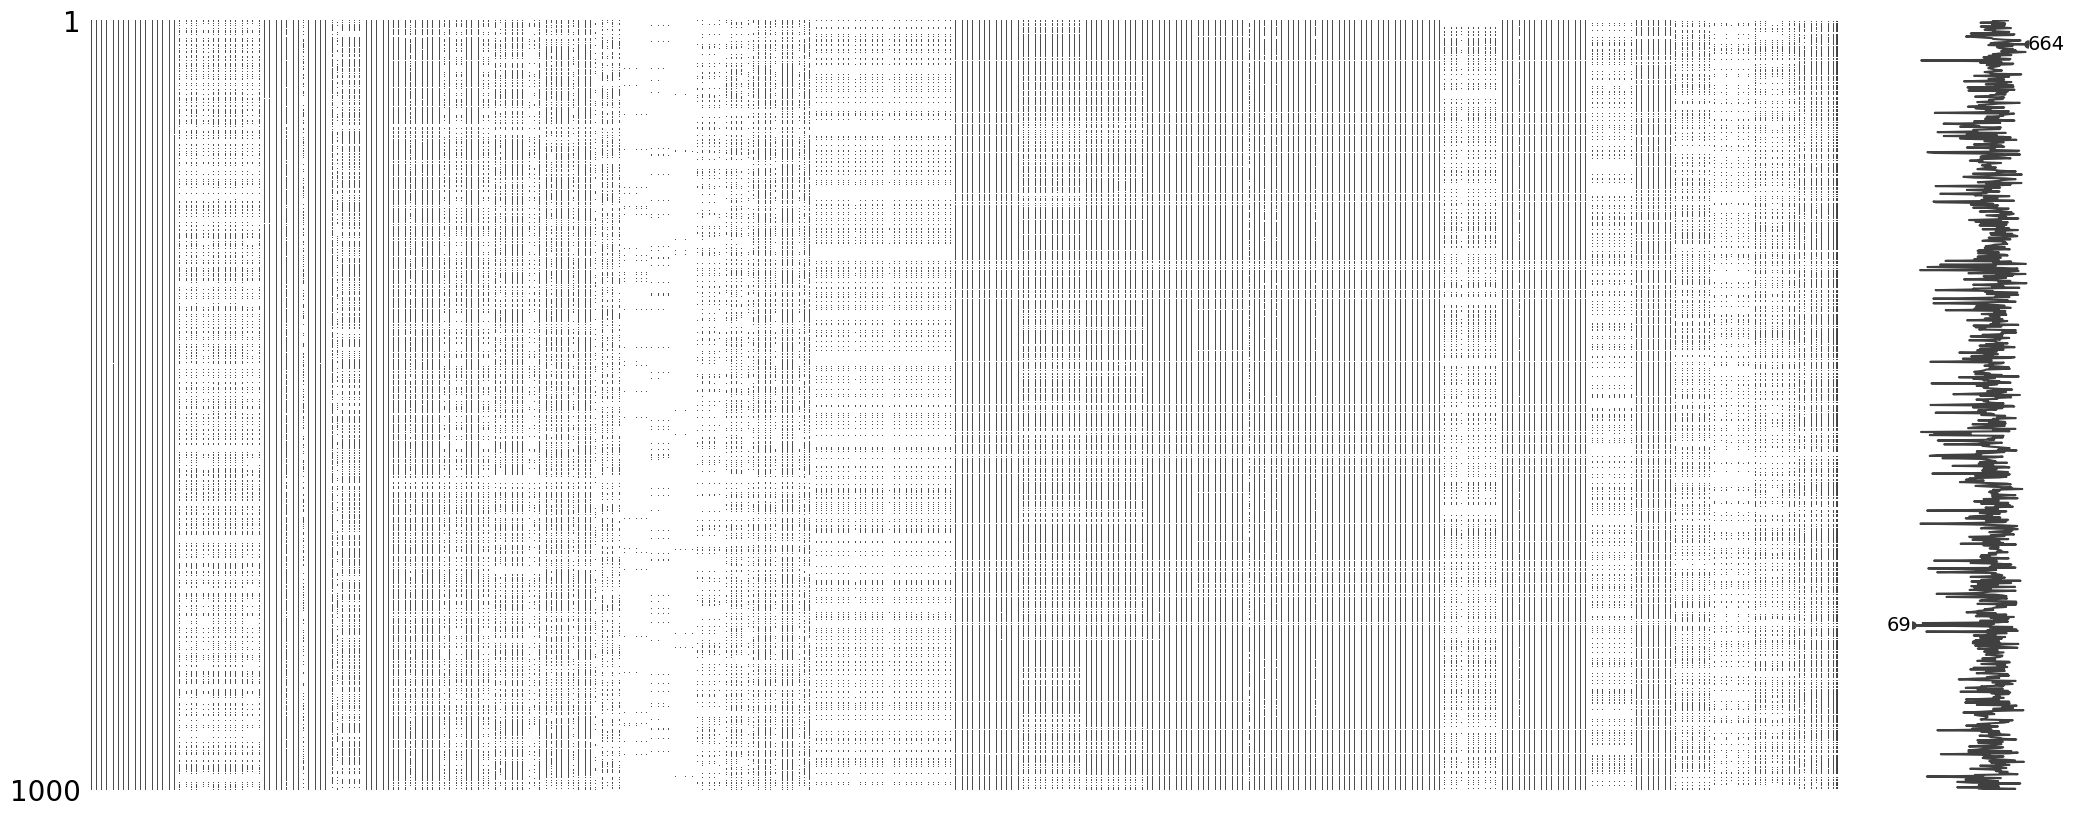

In [42]:
# Values presence on a sample
msno.matrix(df.sample(1000))
plt.show()

In [49]:
# complete columns and number
complete_cols = list(df.columns.values[df.notnull().mean() == 1])
print(complete_cols)
len(complete_cols)

['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_WORK_PHONE', 'OCCUPATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_18', 'DOCUMENT_COUNT', 'NEW_DOC_KURT', 'AGE_RANGE', 'CREDIT_TO_INCOME_RATIO', 'INCOME_TO_BIRTH_RATIO', 'ID_TO_BIRTH_RATIO', 'CREDIT_TO_ANNUITY_GROUP', 'GROUP2_EXT_SOURCES_MEDIAN', 'GROUP2_INCOME_MEDIAN', 'GROUP2_CREDIT_TO_ANNUITY_MEDIAN', 'GROUP2_CREDIT_MEDIAN', 'GROUP2_ANNUITY_MEDIAN']


42

In [51]:
# content of complete columns
for col in complete_cols:
    print(f'{col} : {df[col].nunique()} uniques values')
    print(df[col].unique())

SK_ID_CURR : 356250 uniques values
[100002 100003 100004 ... 456223 456224 456250]
NAME_CONTRACT_TYPE : 2 uniques values
[0 1]
CODE_GENDER : 2 uniques values
[0 1]
FLAG_OWN_CAR : 2 uniques values
[0 1]
CNT_CHILDREN : 16 uniques values
[ 0  1  2  3  4  7  5  6  8  9 11 12 10 19 14 20]
AMT_INCOME_TOTAL : 2740 uniques values
[202500.  270000.   67500.  ... 271651.5  67905.  310122. ]
AMT_CREDIT : 6480 uniques values
[ 406597.5 1293502.5  135000.  ... 1005813.   477270.   511227. ]
NAME_INCOME_TYPE : 8 uniques values
[0 1 2 3 4 5 6 7]
NAME_EDUCATION_TYPE : 5 uniques values
[0 1 2 3 4]
NAME_FAMILY_STATUS : 6 uniques values
[0 1 2 3 4 5]
NAME_HOUSING_TYPE : 6 uniques values
[0 1 2 3 4 5]
REGION_POPULATION_RELATIVE : 82 uniques values
[0.0188   0.003542 0.01003  0.00802  0.02866  0.0358   0.003122 0.01863
 0.01968  0.0228   0.01522  0.03134  0.01662  0.01001  0.0207   0.01096
 0.04623  0.02516  0.006294 0.0264   0.01804  0.0191   0.03076  0.008575
 0.01884  0.006207 0.00918  0.007305 0.007114

# 8.  [&#9650;](#toc0_) <a id='toc8_'></a>Add extra ratio features

In [8]:
def add_ratio_features(df):
    """Add division between features - highly effective for GBDT models.

    Arguments:
        df: pandas DataFrame with features from all csv files

    Returns:
        df: Same DataFrame with the new features
    """
    df = df.copy()
    ratio_features = {
        # CREDIT TO INCOME RATIO
        'BUREAU_INCOME_CREDIT_RATIO':
            ['BUREAU_AMT_CREDIT_SUM_MEAN', 'AMT_INCOME_TOTAL'],
        'BUREAU_ACTIVE_CREDIT_TO_INCOME_RATIO':
            ['BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM', 'AMT_INCOME_TOTAL'],
        # PREVIOUS TO CURRENT CREDIT RATIO
        'CURRENT_TO_APPROVED_CREDIT_MIN_RATIO':
            ['APPROVED_AMT_CREDIT_MIN', 'AMT_CREDIT'],
        'CURRENT_TO_APPROVED_CREDIT_MAX_RATIO':
            ['APPROVED_AMT_CREDIT_MAX', 'AMT_CREDIT'],
        'CURRENT_TO_APPROVED_CREDIT_MEAN_RATIO': 
            ['APPROVED_AMT_CREDIT_MEAN', 'AMT_CREDIT'],
        # PREVIOUS TO CURRENT ANNUITY RATIO
        'CURRENT_TO_APPROVED_ANNUITY_MAX_RATIO':
            ['APPROVED_AMT_ANNUITY_MAX', 'AMT_ANNUITY'],
        'CURRENT_TO_APPROVED_ANNUITY_MEAN_RATIO':
            ['APPROVED_AMT_ANNUITY_MEAN', 'AMT_ANNUITY'],
        'PAYMENT_MIN_TO_ANNUITY_RATIO':
            ['INS_AMT_PAYMENT_MIN', 'AMT_ANNUITY'],
        'PAYMENT_MAX_TO_ANNUITY_RATIO':
            ['INS_AMT_PAYMENT_MAX', 'AMT_ANNUITY'],
        'PAYMENT_MEAN_TO_ANNUITY_RATIO':
            ['INS_AMT_PAYMENT_MEAN', 'AMT_ANNUITY'],
        # BUREAU TO CURRENT ANNUITY RATIO
        'CURRENT_TO_BUREAU_ANNUITY_MEAN_RATIO':
            ['BUREAU_AMT_ANNUITY_MEAN', 'AMT_ANNUITY'],
        # PREVIOUS TO CURRENT CREDIT TO ANNUITY RATIO
        'CTA_CREDIT_TO_ANNUITY_MAX_RATIO':
            ['APPROVED_CREDIT_TO_ANNUITY_RATIO_MAX', 'CREDIT_TO_ANNUITY_RATIO'],
        'CTA_CREDIT_TO_ANNUITY_MEAN_RATIO':
            ['APPROVED_CREDIT_TO_ANNUITY_RATIO_MEAN', 'CREDIT_TO_ANNUITY_RATIO'],
        # DAYS AND TIME DIFFERENCES AND RATIOS
        'DAYS_DECISION_MEAN_TO_BIRTH':
            ['APPROVED_DAYS_DECISION_MEAN', 'DAYS_BIRTH'],
        'DAYS_CREDIT_MEAN_TO_BIRTH':
            ['BUREAU_DAYS_CREDIT_MEAN', 'DAYS_BIRTH'],
        'DAYS_DECISION_MEAN_TO_EMPLOYED':
            ['APPROVED_DAYS_DECISION_MEAN', 'DAYS_EMPLOYED'],
        'DAYS_CREDIT_MEAN_TO_EMPLOYED':
            ['BUREAU_DAYS_CREDIT_MEAN', 'DAYS_EMPLOYED'],
        'HOUR_APPR_RATIO':
            ['HOUR_APPR_PROCESS_START', 'PREV_HOUR_APPR_PROCESS_START_MEAN'],
    }
    for ratio_feature, features in ratio_features.items():
        df[ratio_feature] = df[features[0]] / df[features[1]]
    # Hour: difference from previous applications
    df['HOUR_APPR_DIFFERENCE'] = df['HOUR_APPR_PROCESS_START'] - df['PREV_HOUR_APPR_PROCESS_START_MEAN']
    return df


def add_groupby_features(df):
    """Group some features by duration (credit/annuity) and extract the mean, median and std.

    Arguments:
        df: pandas DataFrame with features from all csv files

    Returns:
        df: Same DataFrame with the new features
    """
    g = 'CREDIT_TO_ANNUITY_RATIO'
    feats = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'BUREAU_ACTIVE_DAYS_CREDIT_MEAN',
             'APPROVED_CNT_PAYMENT_MEAN', 'EXT_SOURCES_PROD', 'CREDIT_TO_GOODS_RATIO',
             'INS_DAYS_ENTRY_PAYMENT_MAX', 'EMPLOYED_TO_BIRTH_RATIO', 'EXT_SOURCES_MEAN',
             'DAYS_REGISTRATION', 'DAYS_EMPLOYED', 'DAYS_BIRTH']
    agg = df.groupby(g)[feats].agg(['mean', 'median', 'std'])
    agg.columns = pd.Index(['CTAR_' + e[0] + '_' + e[1].upper() for e in agg.columns.tolist()])
    df = df.join(agg, how='left', on=g)
    del agg
    gc.collect()
    return df

In [9]:
df = add_ratio_features(df)

In [10]:
df.shape

(356250, 737)

In [15]:
df.index = df.SK_ID_CURR
df = df.drop('SK_ID_CURR', axis=1)
df.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,PAYMENT_MEAN_TO_ANNUITY_RATIO,CURRENT_TO_BUREAU_ANNUITY_MEAN_RATIO,CTA_CREDIT_TO_ANNUITY_MAX_RATIO,CTA_CREDIT_TO_ANNUITY_MEAN_RATIO,DAYS_DECISION_MEAN_TO_BIRTH,DAYS_CREDIT_MEAN_TO_BIRTH,DAYS_DECISION_MEAN_TO_EMPLOYED,DAYS_CREDIT_MEAN_TO_EMPLOYED,HOUR_APPR_RATIO,HOUR_APPR_DIFFERENCE
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0,...,0.467976,0.0,1.175170,1.175170,0.064052,0.092379,0.951172,1.372070,1.111328,1.000000
100003,0.0,0,1,0,0,270000.0,1293502.5,35698.5,1129500.0,1,...,1.813930,NaN,0.290785,0.239585,0.077841,0.083567,1.098633,1.179688,0.750000,-3.664062
100004,0.0,1,0,1,0,67500.0,135000.0,6750.0,135000.0,0,...,1.051282,NaN,0.187652,0.187652,0.042791,0.045521,3.623047,3.853516,1.799805,4.000000
100006,0.0,0,1,0,0,135000.0,312682.5,29686.5,297000.0,0,...,2.120394,NaN,2.643527,1.497926,0.018179,NaN,0.113647,NaN,1.159180,2.335938
100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,0,...,0.558600,NaN,0.931385,0.538762,0.061359,0.057646,0.402588,0.378174,0.891602,-1.335938


In [18]:
df.to_pickle(
    "./pickle_files/features.pkl.gz",
    compression={'method': 'gzip', 'compresslevel': 1, 'mtime': 1}
)

# Explore features

In [3]:
df = pd.read_pickle('./pickle_files/features.pkl.gz')

In [4]:
df.shape

(356250, 736)

In [23]:
# Retain values with a target
df = df[df.TARGET.notnull()]
df.shape

(307506, 736)

In [24]:
def class_percentages(target):
    """
    Print percentages of each element in target.
    """
    display(target.value_counts() * 100 / len(target))
    return None    

In [25]:
class_percentages(df.TARGET)

TARGET
0.0    91.927312
1.0     8.072688
Name: count, dtype: float64

## Features with NaN

In [34]:
mask_nan_atleast10per = df.isnull().mean() > 0.1
print(f"number of features with at least 10% of missing values :" 
      f"{df.loc[:, mask_nan_atleast10per].shape[1]}")

mask_nan_atleast50per = df.isnull().mean() > 0.5
print(f"number features with at least 50% of missing values : "
      f"{df.loc[:, mask_nan_atleast50per].shape[1]}")

number of features with at least 10% of missing values :482
number features with at least 50% of missing values : 262


## Individuals with NaN

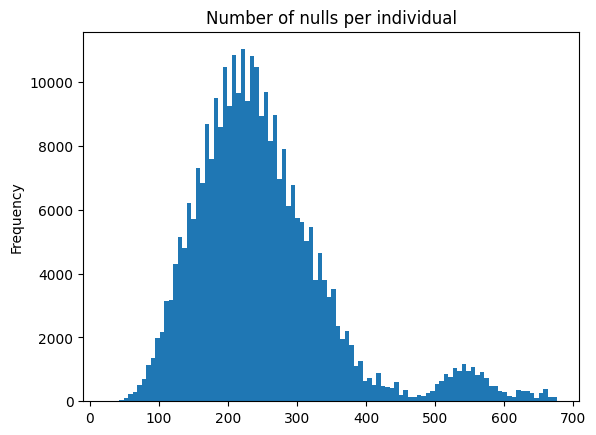

In [26]:
(    
    df
    .isnull()
    .sum(axis=1)
    .plot(
        kind='hist', 
        bins=100,
        title='Number of nulls per individual',
    )
)
plt.show()

In [13]:
def keep_individual_with_info(data, threshold=400):
    """ Remove individuals with more than `threshold` null values.
    
    The default value of 400 is based on the histogram of null values per
    individual."""
    print(f">>> Filtering individual with more than {threshold} values")
    print(f"before : {len(data)}")
    mask = (data.isnull().sum(axis=1) > 400)
    df = data.copy().loc[~mask, :]
    print(f"after : {len(df)}")
    del data
    gc.collect()
    return df

In [27]:
df = keep_individual_with_info(df)

>>> Filtering individual with more than 400 values
before : 307506
after : 286952


In [28]:
class_percentages(df.TARGET)

TARGET
0.0    91.859266
1.0     8.140734
Name: count, dtype: float64

Target distribution remains the same.

## features with inf

Inf values can not be handle by many ML models so I want to understand where they appear and decide what to do with it.

In [29]:
df.shape

(286952, 736)

In [30]:
# compute num of inf and -inf values
((df == np.inf)|(df == -np.inf)).sum().sum()

466154

In [75]:
# Extract the df part with inf values
df_with_pos_inf = df.loc[:, ((df == np.inf)).sum() > 0]
df_with_neg_inf = df.loc[:, ((df == -np.inf)).sum() > 0]
df_with_inf = df.loc[:, ((df == -np.inf)|(df == np.inf)).sum() > 0]

In [76]:
df_with_neg_inf.shape

(286952, 14)

In [77]:
df_with_pos_inf.shape

(286952, 41)

In [78]:
df_with_inf.shape

(286952, 53)

In [42]:
((df_with_inf == np.inf)|(df_with_inf == -np.inf)).sum()

INCOME_TO_EMPLOYED_RATIO                          2
BUREAU_ACTIVE_DEBT_PERCENTAGE_MEAN            24005
BUREAU_ACTIVE_CREDIT_TO_ANNUITY_RATIO_MEAN    12206
BUREAU_CONSUMER_DEBT_PERCENTAGE_MEAN          39422
BUREAU_CREDIT_DEBT_PERCENTAGE_MEAN            44447
BUREAU_MORTGAGE_DEBT_PERCENTAGE_MEAN           2403
BUREAU_CAR_DEBT_PERCENTAGE_MEAN                7651
BUREAU_MICROLOAN_DEBT_PERCENTAGE_MEAN           969
BUREAU_LAST6M_DEBT_PERCENTAGE_MEAN             8612
BUREAU_LAST12M_DEBT_PERCENTAGE_MEAN           22475
BUREAU_LAST24M_DEBT_PERCENTAGE_MEAN           39498
BUREAU_LAST36M_DEBT_PERCENTAGE_MEAN           40344
BUREAU_DEBT_OVER_CREDIT                          52
BUREAU_ACTIVE_DEBT_OVER_CREDIT                  236
CC_LIMIT_USE_MAX                                636
CC_LIMIT_USE_MEAN                                80
CC_PAYMENT_DIV_MIN_MIN                         1600
CC_PAYMENT_DIV_MIN_MEAN                        2445
CC_12M_LIMIT_USE_MAX                            636
CC_12M_LIMIT

All inf values are in 53 features out of 736.

We can note that some contains loads of inf values and some feature only a very few.

In [79]:
inf_features = df_with_inf.columns

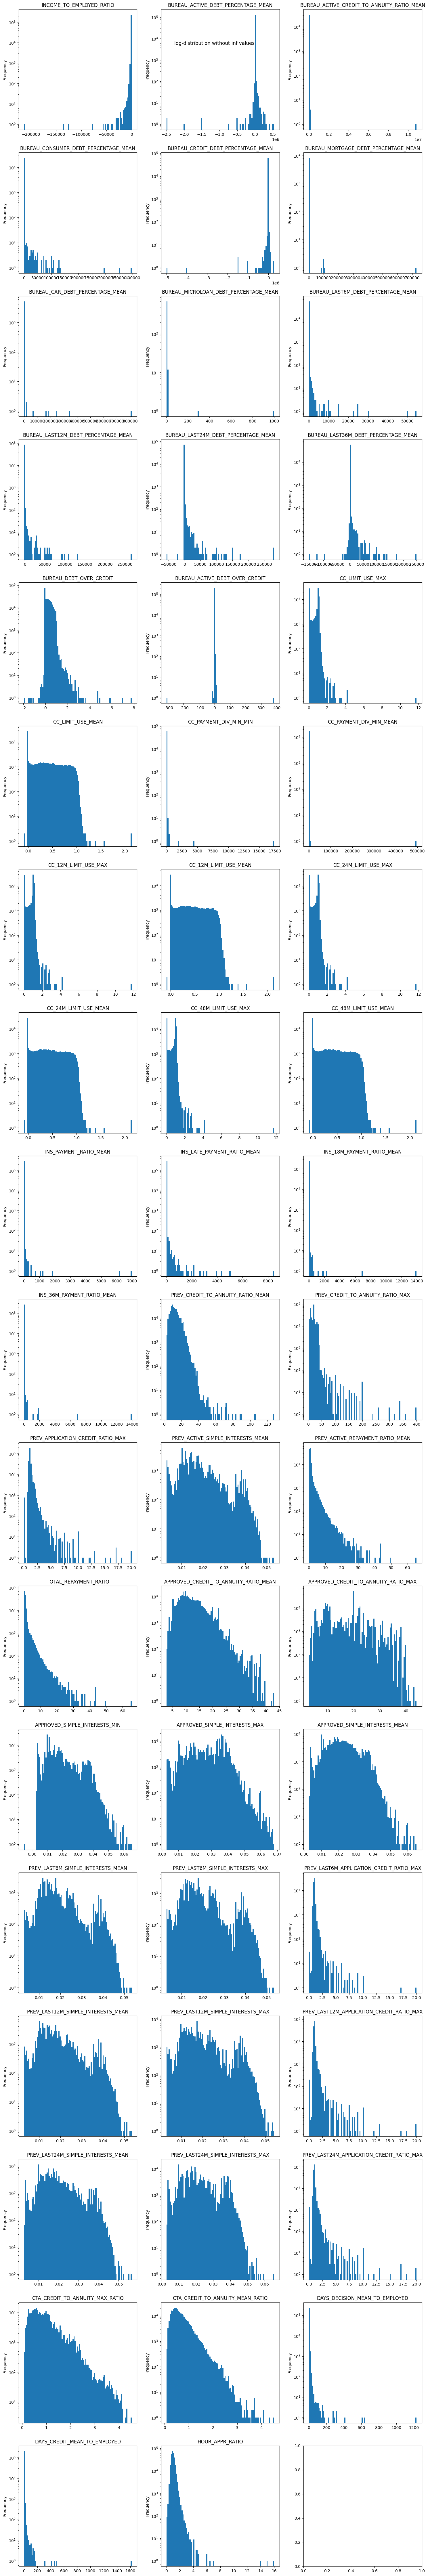

In [37]:
fig, axs = plt.subplots(18, 3, figsize=(3*5, 18*5))

for feat, ax in zip(inf_features, axs.flat):
    (
        df[feat]
        .replace(np.inf, np.nan)
        .replace(-np.inf, np.nan)
        .plot(kind='hist', bins=100, ax=ax, log=True, title=f'{feat}')
    )
plt.suptitle('log-distribution without inf values') 
plt.tight_layout()   
plt.show()

In [66]:
# Depending if the feature has positive or/and negative inf values, search
# the last or/and first percentile and clip exceeding value to it. 
high_percentiles = (
    df_with_pos_inf
    .replace(np.inf, np.NaN)
    .apply(np.nanpercentile, q=99.9, axis=0)
)
high_percentiles.name = "high_percentiles"
high_percentiles 

INCOME_TO_EMPLOYED_RATIO                         -5.932514
BUREAU_ACTIVE_DEBT_PERCENTAGE_MEAN            32601.814100
BUREAU_ACTIVE_CREDIT_TO_ANNUITY_RATIO_MEAN     9941.602880
BUREAU_CONSUMER_DEBT_PERCENTAGE_MEAN          50000.099358
BUREAU_CREDIT_DEBT_PERCENTAGE_MEAN            10000.000000
BUREAU_MORTGAGE_DEBT_PERCENTAGE_MEAN           2164.904548
BUREAU_CAR_DEBT_PERCENTAGE_MEAN               58776.189056
BUREAU_MICROLOAN_DEBT_PERCENTAGE_MEAN           497.400000
BUREAU_LAST6M_DEBT_PERCENTAGE_MEAN             1241.666349
BUREAU_LAST12M_DEBT_PERCENTAGE_MEAN            3333.333333
BUREAU_LAST24M_DEBT_PERCENTAGE_MEAN           16496.558048
BUREAU_LAST36M_DEBT_PERCENTAGE_MEAN           22224.102853
BUREAU_DEBT_OVER_CREDIT                           1.284711
BUREAU_ACTIVE_DEBT_OVER_CREDIT                    1.858756
CC_LIMIT_USE_MAX                                  1.386030
CC_LIMIT_USE_MEAN                                 1.059548
CC_PAYMENT_DIV_MIN_MIN                           42.4125

In [65]:
low_percentiles = (
    df_with_neg_inf
    .replace(-np.inf, np.NaN)
    .apply(np.nanpercentile, q=0.01, axis=0)
)
low_percentiles.name = "low_percentiles"

low_percentiles 

BUREAU_DEBT_OVER_CREDIT              -0.105542
BUREAU_ACTIVE_DEBT_OVER_CREDIT       -0.531323
PREV_ACTIVE_SIMPLE_INTERESTS_MEAN     0.002903
APPROVED_SIMPLE_INTERESTS_MIN         0.002740
APPROVED_SIMPLE_INTERESTS_MAX         0.002903
APPROVED_SIMPLE_INTERESTS_MEAN        0.002903
PREV_LAST6M_SIMPLE_INTERESTS_MEAN     0.002903
PREV_LAST6M_SIMPLE_INTERESTS_MAX      0.002903
PREV_LAST12M_SIMPLE_INTERESTS_MEAN    0.002903
PREV_LAST12M_SIMPLE_INTERESTS_MAX     0.002903
PREV_LAST24M_SIMPLE_INTERESTS_MEAN    0.002788
PREV_LAST24M_SIMPLE_INTERESTS_MAX     0.002903
DAYS_DECISION_MEAN_TO_EMPLOYED        0.002576
DAYS_CREDIT_MEAN_TO_EMPLOYED          0.002908
Name: low_percentiles, dtype: float64

In [68]:
# Concatenate boundaries to then clip values
boundaries = pd.concat([low_percentiles, high_percentiles], axis=1)
boundaries

,low_percentiles,high_percentiles
BUREAU_DEBT_OVER_CREDIT,-0.105542,1.284711
BUREAU_ACTIVE_DEBT_OVER_CREDIT,-0.531323,1.858756
PREV_ACTIVE_SIMPLE_INTERESTS_MEAN,0.002903,NaN
APPROVED_SIMPLE_INTERESTS_MIN,0.002740,NaN
APPROVED_SIMPLE_INTERESTS_MAX,0.002903,NaN
APPROVED_SIMPLE_INTERESTS_MEAN,0.002903,NaN
PREV_LAST6M_SIMPLE_INTERESTS_MEAN,0.002903,NaN
PREV_LAST6M_SIMPLE_INTERESTS_MAX,0.002903,NaN
PREV_LAST12M_SIMPLE_INTERESTS_MEAN,0.002903,NaN
PREV_LAST12M_SIMPLE_INTERESTS_MAX,0.002903,NaN


In [69]:
boundaries.shape

(53, 2)

In [80]:
df_with_inf.shape

(286952, 53)

In [97]:
clipped_df = df.loc[:, list(boundaries.index)].clip(
    lower=boundaries.low_percentiles,
    upper=boundaries.high_percentiles,
    axis=1,
)

In [98]:
clipped_df.describe()

,BUREAU_DEBT_OVER_CREDIT,BUREAU_ACTIVE_DEBT_OVER_CREDIT,PREV_ACTIVE_SIMPLE_INTERESTS_MEAN,APPROVED_SIMPLE_INTERESTS_MIN,APPROVED_SIMPLE_INTERESTS_MAX,APPROVED_SIMPLE_INTERESTS_MEAN,PREV_LAST6M_SIMPLE_INTERESTS_MEAN,PREV_LAST6M_SIMPLE_INTERESTS_MAX,PREV_LAST12M_SIMPLE_INTERESTS_MEAN,PREV_LAST12M_SIMPLE_INTERESTS_MAX,...,PREV_ACTIVE_REPAYMENT_RATIO_MEAN,TOTAL_REPAYMENT_RATIO,APPROVED_CREDIT_TO_ANNUITY_RATIO_MEAN,APPROVED_CREDIT_TO_ANNUITY_RATIO_MAX,PREV_LAST6M_APPLICATION_CREDIT_RATIO_MAX,PREV_LAST12M_APPLICATION_CREDIT_RATIO_MAX,PREV_LAST24M_APPLICATION_CREDIT_RATIO_MAX,CTA_CREDIT_TO_ANNUITY_MAX_RATIO,CTA_CREDIT_TO_ANNUITY_MEAN_RATIO,HOUR_APPR_RATIO
count,248556.000000,203736.000000,127215.000000,286032.000000,286032.000000,230602.000000,55500.000000,59938.000000,119872.000000,139012.000000,...,123468.000000,140485.000000,286026.000000,286032.000000,61667.000000,141414.000000,226457.000000,286020.000000,286014.000000,286593.000000
mean,0.284422,0.529509,0.011894,0.012572,0.027212,0.019463,0.016598,0.017768,0.015347,0.017875,...,1.142176,0.921346,11.753475,16.257728,0.993760,1.003391,1.009576,0.860329,0.624025,NaN
std,0.289212,0.344870,0.009334,0.009959,0.010912,0.009935,0.009131,0.009129,0.009131,0.009482,...,1.756573,1.457033,4.613075,7.609600,0.197857,0.204803,0.208561,0.518936,0.337567,0.000000
min,-0.105542,-0.531323,0.002903,0.002740,0.002903,0.002903,0.002903,0.002903,0.002903,0.002903,...,0.000000,0.000000,2.737256,2.737256,0.000000,0.000000,0.000000,0.077684,0.077684,0.000000
25%,0.000000,0.226449,0.002903,0.002740,0.018253,0.012263,0.011544,0.011999,0.010005,0.011613,...,0.467500,0.284167,8.532740,9.708738,0.909900,0.926609,0.935191,0.481842,0.386398,0.785645
50%,0.212960,0.586343,0.010939,0.010833,0.029034,0.019402,0.015003,0.015787,0.014102,0.016056,...,0.782720,0.660000,10.870113,17.035225,1.000000,1.000000,1.000000,0.753554,0.545367,0.941406
75%,0.484956,0.823751,0.017412,0.017596,0.036566,0.026154,0.020998,0.022974,0.019403,0.023081,...,1.133400,1.044451,14.496390,20.785705,1.000000,1.000000,1.000000,1.094017,0.784383,1.117188
max,1.284711,1.858756,0.053519,0.065203,0.068113,0.065203,0.053519,0.053519,0.053519,0.054168,...,18.112756,17.225972,34.086799,39.425682,4.000000,4.250000,3.750000,3.591112,2.473992,2.470703


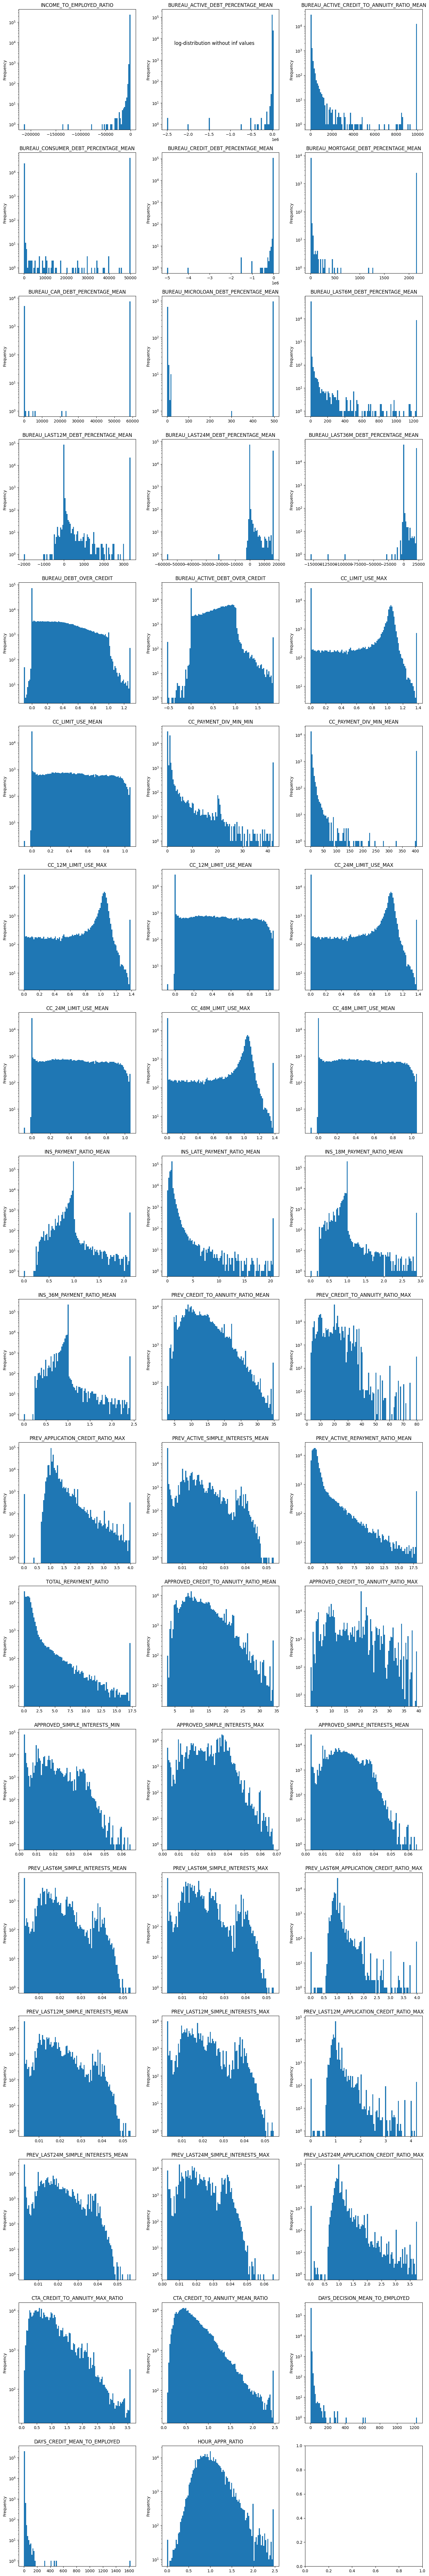

In [100]:
fig, axs = plt.subplots(18, 3, figsize=(3*5, 18*5))

for feat, ax in zip(inf_features, axs.flat):
    (
        clipped_df[feat]
        .plot(kind='hist', bins=100, ax=ax, log=True, title=f'{feat}')
    )
plt.suptitle('log-distribution without inf values') 
plt.tight_layout()   
plt.show()

This is totally convenient.

But I think applying the same process even when there is no inf values can be a good idea too filter outliers, so I am going to generalize it.


In [101]:
df.shape

(286952, 736)

In [5]:
def filter_inf_and_outliers_values(df):
    # In order to filter inf and -inf values and, by the way, filter outliers
    # I search for the 0.01 and the 99.9 percentile (without considering inf
    # values nor nan values). Then I clip values between those.

    # Note : This must not be applied on categorical features
    categorical_features = [
        'CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE',
        'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
        'NAME_INCOME_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE',
        'WEEKDAY_APPR_PROCESS_START'
    ]
    numerical_features = [ft for ft in df.columns if ft not in categorical_features]

    num_df = df.loc[:, numerical_features]

    high_percentiles = (
        num_df
        .replace(np.inf, np.NaN)
        .apply(np.nanpercentile, q=99.9, axis=0)
    )
    high_percentiles.name = "high_percentiles"

    low_percentiles = (
        num_df
        .replace(-np.inf, np.NaN)
        .apply(np.nanpercentile, q=0.01, axis=0)
    )
    low_percentiles.name = "low_percentiles"

    # Concatenate boundaries and clip values
    boundaries = pd.concat([low_percentiles, high_percentiles], axis=1)
    clipped_df = (
        df
        .loc[:, list(boundaries.index)]
        .clip(
            lower=boundaries.low_percentiles,
            upper=boundaries.high_percentiles,
            axis=1,
        )
    )

    df = pd.concat([clipped_df, df[categorical_features]], axis=1)
    del clipped_df
    gc.collect()
    return df

In [6]:
df = filter_inf_and_outliers_values(df)

In [8]:
df.max().max()

292612505600.0

In [9]:
df.min().min()

-38171881.3312